# Data Manipulation

The technique to transform data into acceptable format by the API. These methods involve remove bad data, missing data, non suiltable format. Then group them for analysis.

## Clustering

Clustering techniques are unsupervised learning algorithms that try to group unlabelled data into "clusters", using the (typically spatial) structure of the data itself.

The easiest way to demonstrate how clustering works is to simply generate some data and show them in action. We'll start off by importing the libraries we'll be using today.

In [1]:
import math, matplotlib.pyplot as plt, operator, torch
torch.manual_seed(1);

### Create data

In [2]:
n_clusters=6
n_samples =250

To generate our data, we're going to pick 6 random points, which we'll call centroids, and for each point we're going to generate 250 random points about it.

In [9]:
centroids = torch.randint(-35, 35, (n_clusters, 2)).float()
centroids

tensor([[-22.,  18.],
        [ 13.,  -7.],
        [-35.,   7.],
        [ 21.,   8.],
        [ 24., -27.],
        [ -4., -32.]])

### Gaussian Distribution

using Pytorch MultivariateNormal create a Gaussian distribution around the centroids

In [4]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [5]:
def sample(m): 
    return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,)  # type: ignore  # type: ignore)

In [6]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices)

Below we can see each centroid marked with the X, and the coloring associated to each respective cluster.

In [7]:
def plot_data(centroids, data, n_samples):
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        plt.scatter(samples[:,0], samples[:,1], s=1)
        plt.plot(centroid[0], centroid[1], markersize=10, marker="x", color='k', mew=5)
        plt.plot(centroid[0], centroid[1], markersize=5, marker="x", color='m', mew=2)

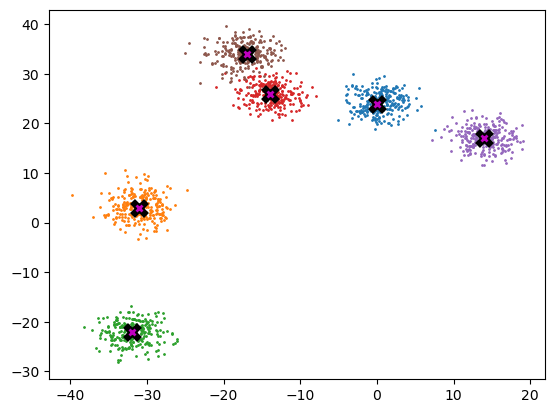

In [8]:
plot_data(centroids, data, n_samples)

### Mean shift

Another technique for grouping data for analystical operation.

Most people that have come across clustering algorithms have learnt about **k-means**. Mean shift clustering is a newer and less well-known approach, but it has some important advantages:
* It doesn't require selecting the number of clusters in advance, but instead just requires a **bandwidth** to be specified, which can be easily chosen automatically
* It can handle clusters of any shape, whereas k-means (without using special extensions) requires that clusters be roughly ball shaped.

The algorithm is as follows:
* For each data point x in the sample X, find the distance between that point x and every other point in X
* Create weights for each point in X by using the **Gaussian kernel** of that point's distance to x
    * This weighting approach penalizes points further away from x
    * The rate at which the weights fall to zero is determined by the **bandwidth**, which is the standard deviation of the Gaussian
* Update x as the weighted average of all other points in X, weighted based on the previous step

This will iteratively push points that are close together even closer until they are next to each other.

So here's the definition of the gaussian kernel, which you may remember from high school...

$$\color{orange}{  g(x) = \frac{1}{\sigma\sqrt{2\pi}} \exp\left( -\frac{1}{2} \frac{(x - \mu)^2}{\sigma^2} \right)}$$

Gaussian functions are often used to represent the *probability density function* of a *normally distributed random variable* with *expected value* $\color{orange}{ μ = b}$ and *variance* $\color{orange}{ σ^2 = c^2}$

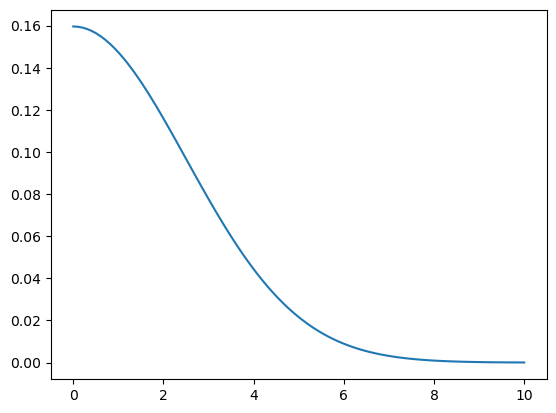

In [10]:
def gaussian(d, bw): return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

x = torch.linspace(0,10,100)
plt.plot(x, gaussian(x,2.5));

 This person at the science march certainly remembered!

<img src="http://i.imgur.com/nijQLHw.jpg" width=400>

In our implementation, we choose the bandwidth to be 2.5. 

One easy way to choose bandwidth is to find which bandwidth covers one third of the data.

In [11]:
X = data.clone()
x = data[0]
dist = torch.sqrt(((x-X)**2).sum(1))
dist[:8]

tensor([0.0000, 1.4130, 3.2164, 2.8909, 4.5990, 3.1394, 3.9166, 5.3368])

In [12]:
weight = gaussian(dist, 2.5)
weight

tensor([1.5958e-01, 1.3602e-01, 6.9749e-02,  ..., 3.5634e-09, 1.7959e-10,
        2.7274e-16])

In [13]:
weight.shape,X.shape

(torch.Size([1500]), torch.Size([1500, 2]))

In [14]:
(weight[:,None]*X)

tensor([[-2.1094e-01,  3.9275e+00],
        [-2.9346e-01,  3.1928e+00],
        [-1.0870e-01,  1.4929e+00],
        ...,
        [-5.0652e-08,  1.1388e-07],
        [-2.6280e-09,  6.0300e-09],
        [-4.7550e-15,  1.0221e-14]])

In [15]:
def meanshift(data):
    X = data.clone()
    for it in range(5):
        for i, x in enumerate(X):
            dist = torch.sqrt(((x-X)**2).sum(1))
            weight = gaussian(dist, 2.5)
            X[i] = (weight[:,None]*X).sum(0)/weight.sum()
    return X

In [16]:
%time X=meanshift(data)

CPU times: user 1.63 s, sys: 5.81 ms, total: 1.64 s
Wall time: 1.64 s


We can see that mean shift clustering has almost reproduced our original clustering. The one exception are the very close clusters, but if we really wanted to differentiate them we could lower the bandwidth.

What is impressive is that this algorithm nearly reproduced the original clusters without telling it how many clusters there should be.

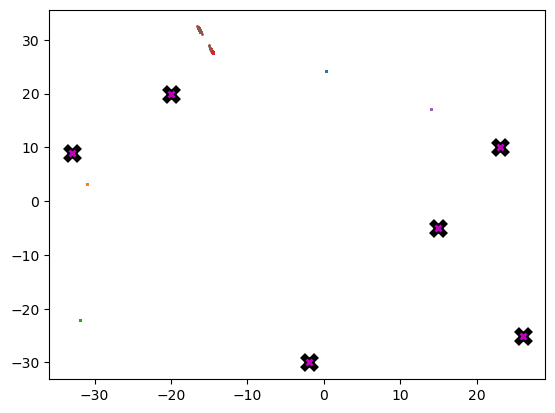

In [17]:
plot_data(centroids+2, X, n_samples)

All the computation is happening in the <tt>for</tt> loop, which isn't accelerated by pytorch. Each iteration launches a new cuda kernel, which takes time and slows the algorithm down as a whole. Furthermore, each iteration doesn't have enough processing to do to fill up all of the threads of the GPU. But at least the results are correct...

We should be able to accelerate this algorithm with a GPU.

## GPU batched algorithm

To truly accelerate the algorithm, we need to be performing updates on a batch of points per iteration, instead of just one as we were doing.

In [18]:
def dist_b(a,b): return torch.sqrt(((a[None]-b[:,None])**2).sum(2))

In [19]:
X=torch.rand(8,2)
x=torch.rand(5,2)
dist_b(X, x)

tensor([[0.5419, 0.5264, 0.0960, 0.3454, 0.8643, 0.1899, 0.7796, 0.6076],
        [0.6308, 0.7128, 0.4591, 0.6628, 0.8456, 0.2362, 0.7192, 0.2356],
        [0.3855, 0.4610, 0.3770, 0.4507, 0.6446, 0.2919, 0.5365, 0.4175],
        [0.4754, 0.6117, 0.6203, 0.6832, 0.5965, 0.4708, 0.4604, 0.2721],
        [0.2356, 0.2975, 0.4038, 0.3401, 0.5405, 0.4133, 0.4581, 0.5667]])

In [20]:
bs=5
X = data.clone()
x = X[:bs]
weight = gaussian(dist_b(X, x), 2)
weight

tensor([[1.9947e-01, 1.5541e-01, 5.4735e-02,  ..., 2.2132e-13, 2.0775e-15,
         1.6831e-24],
        [1.5541e-01, 1.9947e-01, 1.1173e-01,  ..., 3.1427e-13, 2.0317e-15,
         9.7350e-25],
        [5.4735e-02, 1.1173e-01, 1.9947e-01,  ..., 3.5939e-16, 9.4595e-19,
         3.9723e-29],
        [7.0175e-02, 3.1377e-02, 1.8560e-02,  ..., 5.2249e-18, 3.3886e-20,
         3.0925e-30],
        [1.4180e-02, 3.1085e-03, 1.1476e-03,  ..., 8.5815e-20, 8.2003e-22,
         9.4978e-32]])

In [21]:
weight.shape,X.shape

(torch.Size([5, 1500]), torch.Size([1500, 2]))

In [22]:
num = (weight[...,None]*X[None]).sum(1)
num.shape

torch.Size([5, 2])

In [23]:
div = weight.sum(1, keepdim=True)
div.shape

torch.Size([5, 1])

In [24]:
num/div

tensor([[-0.5274, 24.3688],
        [-1.0042, 23.6233],
        [-0.7959, 22.5723],
        [ 1.0092, 24.4519],
        [ 1.8587, 25.1916]])

In [25]:
from fastcore.all import chunked

In [26]:
def meanshift(data, bs=500):
    n = len(data)
    X = data.clone()
    for it in range(5):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs,n))
            weight = gaussian(dist_b(X, X[s]), 2)
            num = (weight[...,None]*X[None]).sum(1)
            div = weight.sum(1, keepdim=True)
            X[s] = num/div
    return X

Although each iteration still has to launch a new cuda kernel, there are now fewer iterations, and the acceleration from updating a batch of points more than makes up for it.

In [27]:
data = data.cuda()

In [28]:
X = meanshift(data).cpu()

In [29]:
%timeit -n 1 X = meanshift(data).cpu()

16.2 ms ± 5.78 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


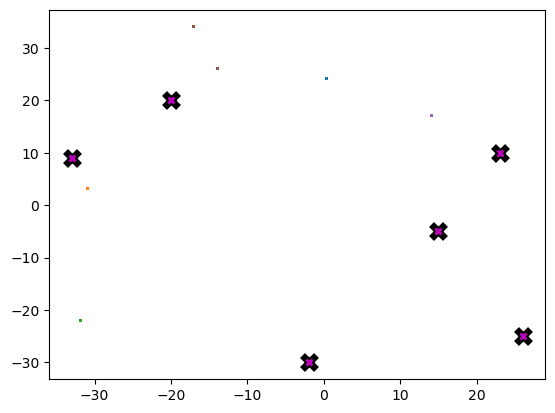

In [30]:
plot_data(centroids+2, X, n_samples)